In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import pymc3 as pm

from modules.models.chapter_5 import estimate_pearson_correlation, estimate_k_coef_agreement, estimate_change_point
from modules.models.chapter_5 import estimate_censored_data, estimate_recapture

from modules.utils import validate_model, visualize_biv_samples, visualize_samples, visualize_time_series

In [3]:
PRPC_KWARGS={
    'samples': 1000
}
SAMPLING_KWARGS={
    'draws': 1000,
    'tune': 3000,
}
POPC_KWARGS={
    'samples': 1000
}

# Estimate Pearson Correlation

In [4]:
corr = 0.5
obs_measurements = np.random.multivariate_normal(
    mean=[0, 0],
    cov = [[1, corr], [corr, 1]],
    size=30
)

model = estimate_pearson_correlation(
    obs_measurements=obs_measurements, 
    lkj_chol_kwargs={
        'eta': 1,
        'sd_dist': pm.HalfCauchy.dist(25)
    }, 
    mu_kwargs={
        'mu': 0,
        'sigma': 1
    }
)

plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS
)
plate

C:\Users\penthotal\Desktop\git_repositories\learning_bayes\books\bayesian_cognitive_modelling\modules\utils.py:29: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sampling_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, Cholesky decomposition]


KeyboardInterrupt: 

In [ ]:
visualize_biv_samples(
    observed=obs_measurements, 
    prpc=prpc['measurements'][0, :, :], 
    popc=popc['measurements'][0, :, :],
    s=40
)

## Estimate Correlation for noisy data

In [ ]:
corr = 0.5
obs_measurements = np.random.multivariate_normal(
    mean=[0, 0],
    cov = [[1, 1*corr], [1*corr, 1]],
    size=30
)
obs_measurements += np.random.normal(0, 1, size=(30, 2))

model = estimate_pearson_correlation(
    obs_measurements=obs_measurements, 
    lkj_chol_kwargs={
        'eta': 1,
        'sd_dist': pm.HalfCauchy.dist(25)
    }, 
    mu_kwargs={
        'mu': 0,
        'sigma': 1
    },
    sigma_kwargs={
        'beta': 25
    }
)

plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS
)
plate

In [ ]:
visualize_biv_samples(
    observed=obs_measurements, 
    prpc=prpc['measurements'][0, :, :], 
    popc=popc['measurements'][0, :, :],
    s=40
)

# Estimate K Coefficient of agreement between judges

In [ ]:
obs_frequencies = np.array([40, 30, 8, 19])

model = estimate_k_coef_agreement(
    obs_frequencies=obs_frequencies, 
    alpha=5,
    beta=5
)
plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS
)
plate

In [ ]:
visualize_samples(
    observed=obs_frequencies, 
    prpc=prpc['obs_frequencies'][0, :], 
    popc=popc['obs_frequencies'][0, :],
    s=80
)

# Estimate Change Point in Time Series

In [ ]:
TS_POPC_KWARGS = {
    'samples': 1000,
    'var_names': ['observed_time_series', 'change_point']
}

t_steps = []
obs_time_series = []
slope = 0.3
change_point = 50
for t in range(150):
    
    if t == 0:
        obs_time_series.append(
            np.random.normal(0, 1) + slope * np.random.normal(0, 1)
        )
    else:
        t_steps.append(t)
        if t <= change_point:
            intercept = np.random.normal(0, 1)
        else:
            intercept = np.random.normal(0.5, 1)
        obs_time_series.append(
            intercept + slope * obs_time_series[t-1]
        )

t_steps = np.array(t_steps)
obs_time_series = np.array(obs_time_series)
        
model = estimate_change_point(
    obs_time_series=obs_time_series, 
    t_steps=t_steps,
    slope_kwargs={
        'mu': 0,
        'sigma': 1
    },
    intercept_kwargs={
        'mu': 0,
        'sigma': 5
    },
    sigma_kwargs={
        'beta': 25
    }
)

plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    TS_POPC_KWARGS
)
plate

In [ ]:
visualize_time_series(
    obs_time_series[1:], 
    prpc=prpc['observed_time_series'], 
    popc=popc['observed_time_series'], 
    change_points=[prpc['change_point'], 50, popc['change_point']],
    figsize=(18, 6)
)

# Estimate Latent Ability From Censored Data

C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
C:\Users\penthotal\Desktop\git_repositories\learning_bayes\books\bayesian_cognitive_modelling\modules\utils.py:29: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sampling_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 209 seconds.
The acceptance probability does not match the target. It is 0.7153590049903198, but should be close to 0.8. Try to increase the number of tuning steps.
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1698: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


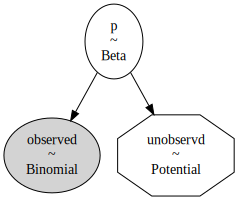

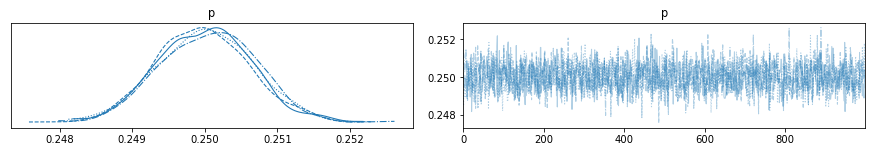

In [13]:
model = estimate_censored_data(
    n_censored_attempts=900, 
    observed_attempt=16, 
    n=30,
    beta_kwargs={
        'alpha': 5,
        'beta': 5
    },
    lower_bound=0, 
    upper_bound=15
)
plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS
)
plate

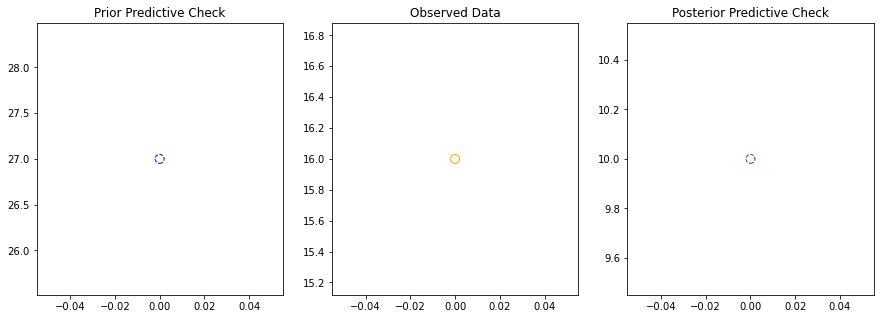

In [16]:
visualize_samples(
    observed=np.array([16]), 
    prpc=prpc['observed'][0], 
    popc=popc['observed'][0],
    s=80
)

# Estimate Size of Population through capture-recapture 

C:\Users\penthotal\Desktop\git_repositories\learning_bayes\books\bayesian_cognitive_modelling\modules\utils.py:29: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sampling_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [population_size]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 189 seconds.
The number of effective samples is smaller than 10% for some parameters.
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


AttributeError: 'numpy.ndarray' object has no attribute 'eval'

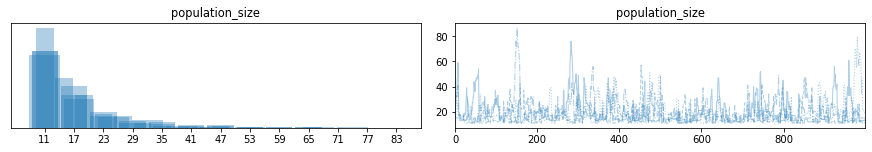

In [12]:
model = estimate_recapture(
    observed_recaptured=4, 
    first_sample=10, 
    second_sample=5,
    discrete_uniform_kwargs={
        'lower': 11,
        'upper': 200
    }
)
plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS
)
plate

In [11]:
visualize_samples(
    observed=[10], 
    prpc=prpc['recaptured'][0, :], 
    popc=popc['recaptured'][0, :],
    s=80
)

NameError: name 'prpc' is not defined

In [23]:
with pm.Model() as model:
    
    x =  pm.HyperGeometric('test', 5, 10, 100)

pm.model_to_graphviz(model)

AttributeError: 'numpy.ndarray' object has no attribute 'eval'

AttributeError: 'numpy.ndarray' object has no attribute 'eval'